## This notebook is written for two reasons
- On server we don't have default scans and it is insanely slow to evaluate the model on original scans.
- This notebook quickly evaluates the model on safetensors bypassing a lot of transforms like resample and lung crop.

- scripts can be found at `scripts/test_safe.py`

In [1]:
import fastcore.all as fc
import pandas as pd 
import numpy as np 

from qct_utils.ctvis.viewer import plot_scans
from copy import deepcopy
from torchvision.transforms import Compose 
from safetensors.numpy import load_file

from voxdet.infer import RetinaInfer
from voxdet.metrics.det_metrics import DetMetrics
from voxdet.metrics.sub_level_analysis import convert2df
from voxdet.retina_test import convert2int, draw_on_ct

/tmp/ipykernel_935649/12863095.py:2: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
ckpt = "../lightning_logs/lidc_exp2/version_5/checkpoints/map_checkpoints/epoch=574-step=25300-val/mAP=0.537.ckpt"
model = RetinaInfer(ckpt, )

Loading backbone from MedCT


In [3]:
model.transforms.transforms[3:]

[voxdet.tfsm.voxt.Norm3d(a_min=-1024.0, a_max=300.0, b_min=0.0, b_max=1.0, clip=True),
 voxdet.tfsm.voxt.PadIfNeeded(sd=32, img_size=None, side='right'),
 voxdet.tfsm.mip.MIP(num_slices=5, mode='max', stride=1, return_stacked_img=True)]

In [4]:
model.transforms = Compose(model.transforms.transforms[3:])
model.transforms

Compose(
    voxdet.tfsm.voxt.Norm3d(a_min=-1024.0, a_max=300.0, b_min=0.0, b_max=1.0, clip=True)
    voxdet.tfsm.voxt.PadIfNeeded(sd=32, img_size=None, side='right')
    voxdet.tfsm.mip.MIP(num_slices=5, mode='max', stride=1, return_stacked_img=True)
)

In [5]:
scans = fc.L(pd.read_csv("../studies/only_lidc/folds1/folds_4.csv")["scans"].values.tolist())
scans

(#176) ['1.3.6.1.4.1.14519.5.2.1.6279.6001.320111824803959660037459294083','1.3.6.1.4.1.14519.5.2.1.6279.6001.299767339686526858593516834230','1.3.6.1.4.1.14519.5.2.1.6279.6001.156990013635454707781600846659','1.3.6.1.4.1.14519.5.2.1.6279.6001.832260670372728970918746541371','1.3.6.1.4.1.14519.5.2.1.6279.6001.259453428008507791234730686014','1.3.6.1.4.1.14519.5.2.1.6279.6001.199171741859530285887752432478','1.3.6.1.4.1.14519.5.2.1.6279.6001.202283133206014258077705539227','1.3.6.1.4.1.14519.5.2.1.6279.6001.453946099750629491201946672998','1.3.6.1.4.1.14519.5.2.1.6279.6001.303865116731361029078599241306','1.3.6.1.4.1.14519.5.2.1.6279.6001.217754016294471278921686508169'...]

In [6]:
scan_loc = "../resources/1.3.6.1.4.1.14519.5.2.1.6279.6001.249404938669582150398726875826.safetensors"
scans = load_file(scan_loc)
scans["images"].shape

(288, 186, 289)

In [7]:
scans["boxes"]

array([[251.34586466, 151.36328125,  45.01171875, 258.83458647,
        158.78515625,  53.91796875],
       [246.35338346, 139.48828125, 187.51171875, 258.83458647,
        149.87890625, 200.12890625],
       [218.89473684,  48.19921875, 258.76171875, 223.88721805,
         53.39453125, 264.69921875],
       [146.5037594 , 158.78515625, 204.58203125, 156.4887218 ,
        168.43359375, 216.45703125],
       [139.01503759, 106.08984375, 255.79296875, 149.        ,
        117.22265625, 269.15234375]])

In [8]:
out = model(scans)

In [9]:
out["boxes"].shape, out["scores"].shape

((33, 6), (33,))

In [10]:
out["scores"]

array([0.9992731 , 0.99838364, 0.99737823, 0.98975986, 0.9775134 ,
       0.9717078 , 0.9420828 , 0.87478364, 0.65368843, 0.5655345 ,
       0.5088162 , 0.46134385, 0.45168856, 0.34845448, 0.32625055,
       0.31384277, 0.30576852, 0.2292586 , 0.18718581, 0.10050561,
       0.09272742, 0.0838104 , 0.08128209, 0.07916456, 0.0738273 ,
       0.0702926 , 0.06878177, 0.06351968, 0.0634888 , 0.05814762,
       0.05742196, 0.055087  , 0.05391586], dtype=float32)

## Visualize outputs 

In [40]:
scans["images"].shape, out["images"].shape

((288, 186, 289), (2, 288, 192, 320))

In [46]:
gt_boxes = convert2int(deepcopy(scans["boxes"]), img_shape=scans["images"].shape)
pred_boxes = convert2int(deepcopy(out["boxes"][out["scores"]>0.9]), img_shape=scans["images"].shape)
gt_boxes.shape, pred_boxes.shape

((5, 6), (7, 6))

In [47]:
gt_boxes

array([[251, 151,  45, 259, 159,  54],
       [246, 139, 187, 259, 150, 201],
       [218,  48, 258, 224,  54, 265],
       [146, 158, 204, 157, 169, 217],
       [139, 106, 255, 149, 118, 270]])

In [48]:
gtimg = draw_on_ct(scans["images"], gt_boxes)
predimg = draw_on_ct(scans["images"], pred_boxes)

In [49]:
plot_scans([gtimg, predimg], ["gtscan", "predscan"])

interactive(children=(RadioButtons(description='Slice plane selection:', index=2, options=('y-z', 'z-x', 'x-y'…

## metrics 

In [50]:
fps = np.linspace(0.0625, 8, num=300)
meters = [
    DetMetrics(iou_thr=j, conf_thr=i, froc_thresholds=fps.tolist())
    for j in [0.1, 0.2, 0.3, 0.4, 0.5]
    for i in [0.9]
]

In [52]:
for meter in meters: meter.update(out["boxes"], out["scores"], scans["boxes"])

In [53]:
metrics = [i.compute() for i in meters]

In [55]:
convert2df(metrics)

,conf,iou,FROC,AP,recall,precision,tp,fp,fn,AP_interp,FROC_interp,FROC_thresholds,avg_tp_iou
0,0.9,0.1,1.0,0.97,1.0,0.71,5.0,2.0,0.0,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...","[0.06, 0.09, 0.12, 0.14, 0.17, 0.2, 0.22, 0.25...",0.61
1,0.9,0.2,1.0,0.97,1.0,0.71,5.0,2.0,0.0,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...","[0.06, 0.09, 0.12, 0.14, 0.17, 0.2, 0.22, 0.25...",0.61
2,0.9,0.3,1.0,0.97,1.0,0.71,5.0,2.0,0.0,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...","[0.06, 0.09, 0.12, 0.14, 0.17, 0.2, 0.22, 0.25...",0.61
3,0.9,0.4,1.0,0.97,1.0,0.71,5.0,2.0,0.0,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...","[0.06, 0.09, 0.12, 0.14, 0.17, 0.2, 0.22, 0.25...",0.61
4,0.9,0.5,1.0,0.97,1.0,0.71,5.0,2.0,0.0,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...","[0.06, 0.09, 0.12, 0.14, 0.17, 0.2, 0.22, 0.25...",0.61


In [61]:
import matplotlib.pyplot as plt
plt.style.use("bmh")
%matplotlib inline

In [67]:
df = pd.read_csv("../weights/lidc/exp1_only_train/metrics.csv")
df.head()

,conf,iou,FROC,AP,recall,precision,tp,fp,fn,AP_interp,FROC_interp,FROC_thresholds,avg_tp_iou
0,0.9,0.1,0.62,0.73,0.65,0.51,331.0,314.0,181.0,"[1.0, 1.0, 0.96, 0.91, 0.79, 0.71, 0.59, 0.51,...","[0.26, 0.31, 0.33, 0.34, 0.36, 0.37, 0.37, 0.3...","[0.06, 0.09, 0.12, 0.14, 0.17, 0.2, 0.22, 0.25...",0.54
1,0.9,0.2,0.61,0.72,0.64,0.51,327.0,318.0,185.0,"[1.0, 1.0, 0.96, 0.91, 0.79, 0.7, 0.58, 0.51, ...","[0.26, 0.29, 0.33, 0.33, 0.35, 0.36, 0.37, 0.3...","[0.06, 0.09, 0.12, 0.14, 0.17, 0.2, 0.22, 0.25...",0.54
2,0.9,0.3,0.60,0.70,0.62,0.49,318.0,327.0,194.0,"[1.0, 0.98, 0.94, 0.86, 0.76, 0.67, 0.54, 0.49...","[0.24, 0.26, 0.28, 0.32, 0.32, 0.34, 0.34, 0.3...","[0.06, 0.09, 0.12, 0.14, 0.17, 0.2, 0.22, 0.25...",0.55
3,0.9,0.4,0.52,0.64,0.55,0.43,280.0,365.0,232.0,"[1.0, 0.96, 0.89, 0.84, 0.68, 0.53, 0.43, 0.43...","[0.2, 0.24, 0.26, 0.27, 0.3, 0.3, 0.31, 0.32, ...","[0.06, 0.09, 0.12, 0.14, 0.17, 0.2, 0.22, 0.25...",0.57
4,0.9,0.5,0.38,0.49,0.39,0.31,202.0,443.0,310.0,"[1.0, 0.86, 0.77, 0.59, 0.31, 0.31, 0.31, 0.31...","[0.12, 0.13, 0.15, 0.17, 0.2, 0.21, 0.22, 0.23...","[0.06, 0.09, 0.12, 0.14, 0.17, 0.2, 0.22, 0.25...",0.62


In [72]:
df[["conf", "iou", "AP", "recall", "precision", "tp", "fp", "fn"]]

,conf,iou,AP,recall,precision,tp,fp,fn
0,0.9,0.1,0.73,0.65,0.51,331.0,314.0,181.0
1,0.9,0.2,0.72,0.64,0.51,327.0,318.0,185.0
2,0.9,0.3,0.70,0.62,0.49,318.0,327.0,194.0
3,0.9,0.4,0.64,0.55,0.43,280.0,365.0,232.0
4,0.9,0.5,0.49,0.39,0.31,202.0,443.0,310.0


In [68]:
df["AP_interp"] = df["AP_interp"].apply(lambda x: eval(x))
df["FROC_interp"] = df["FROC_interp"].apply(lambda x: eval(x))
df["FROC_thresholds"] = df["FROC_thresholds"].apply(lambda x: eval(x))

In [74]:
np.mean(df["FROC_interp"].values[2])

0.595

In [69]:
df["AP_interp"].values[2]

[1.0, 0.98, 0.94, 0.86, 0.76, 0.67, 0.54, 0.49, 0.49, 0.49, 0.49]

In [70]:
np.mean(df["AP_interp"].values[2])

0.700909090909091

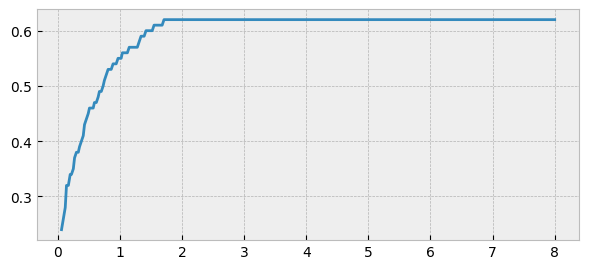

In [71]:
plt.figure(figsize=(7, 3))
plt.plot(df["FROC_thresholds"].values[2], df["FROC_interp"].values[2])
plt.show()